In [1]:
import sys
sys.path.insert(0, '../../../network')
import logging
import argparse
import numpy as np
from network import Population, RateNetwork
from learning import ReachingTask
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity, LinearSynapse, ThresholdPlasticityRule, set_connectivity, corticostriatal
from sequences import GaussianSequence
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
logging.basicConfig(level=logging.INFO)

### Initialization

In [2]:
params = np.load("./ctx-str-params.npz", allow_pickle=True) 
N, sequences, patterns, cp, cw, A = params['N'], params['sequences'], params['patterns'], params['cp'], params['cw'], params['A']

In [3]:
phi = ErrorFunction(mu=0.22, sigma=0.1).phi

plasticity = ThresholdPlasticityRule(x_f=0.85, q_f=0.8)

# populations
ctx = Population(N=N[0], tau=1e-2, phi=phi, name='ctx')
d1 = Population(N=N[1], tau=1e-2, phi=phi, name='d1')

J = set_connectivity([ctx, d1], cp, cw, A, patterns, plasticity)
network = RateNetwork([ctx, d1], J, formulation=3, disable_pbar=False)

INFO:connectivity:Building connections from ctx to ctx
INFO:connectivity:Building connections from ctx to d1
INFO:connectivity:Building connections from d1 to ctx
INFO:connectivity:Building connections from d1 to d1


### Simulation

In [4]:
# # Specific input
init_inputs = [np.zeros(len(patterns[0][0])),
               patterns[1][0]]

T=5#ms
mouse = ReachingTask()
network.simulate_euler2(T, init_inputs[0], init_inputs[1])
# network.simulate_learning(mouse, T, init_inputs, patterns, plasticity, (40, 1400, 0.05, 0.6), noise=[0.13,0.13,0.13], 
#                           b = [0.05, 0.013, 0.02, 0.05], env=5, learning=False, r_ext=[lambda t:0, lambda t: 1], print_output=False, disable_pbar=False)

INFO:network:Integrating network dynamics
100%|██████████| 4999/4999 [00:20<00:00, 244.67it/s]


### Results

In [5]:
overlaps_ctx = sequences[0][0].overlaps(network.pops[0])
overlaps_d1 = sequences[1][0].overlaps(network.pops[1])
# overlaps_d2 = sequences[2][0].overlaps(network.po725206ps[2])
# filename = 'simulation-test'
np.savez('/work/jp464/striatum-sequence/' + 'simulation-pre-learning' + '.npz', 
         overlaps_ctx=overlaps_ctx, overlaps_d1=overlaps_d1, 
         state_ctx=network.pops[0].state, state_d1=network.pops[1].state)

INFO:sequences:Computing overlaps
100%|██████████| 4/4 [00:00<00:00, 21.81it/s]
INFO:sequences:Computing overlaps
100%|██████████| 4/4 [00:00<00:00, 203.90it/s]


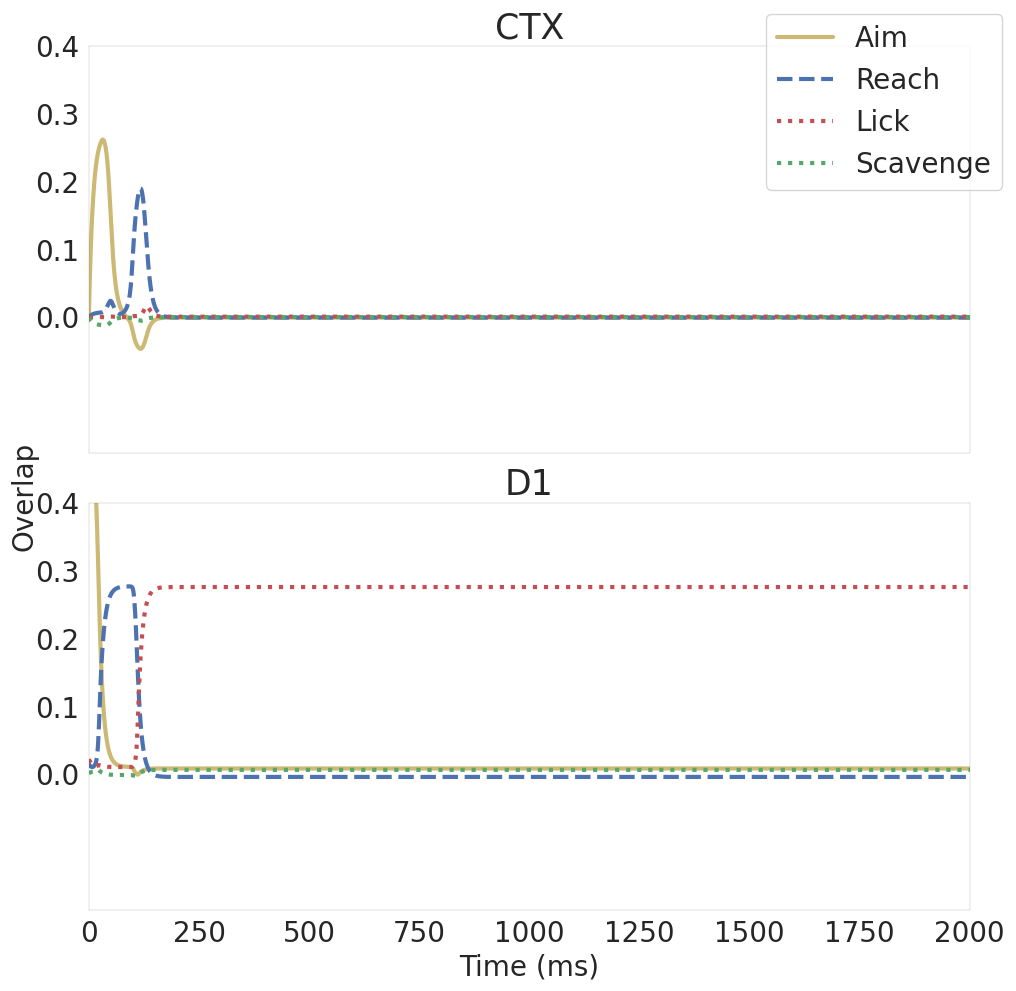

In [6]:
sns.set_style('white') 
colors = sns.color_palette('deep')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams['axes.linewidth'] = 0.1

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, tight_layout=True, figsize=(10,10))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=3, color=colors[8], label='Aim')
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=3, color=colors[0], label='Reach')
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=3, color=colors[3], label='Lick')
axes[0].plot(overlaps_ctx[3], linestyle='dotted', linewidth=3, color=colors[2], label='Scavenge')
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=25)
# axes.set_xlabel('Time (ms)', fontsize=20)
axes[1].plot(overlaps_d1[0], linestyle='solid', linewidth=3, color=colors[8])
axes[1].plot(overlaps_d1[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[1].plot(overlaps_d1[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[1].plot(overlaps_d1[3], linestyle='dotted', linewidth=3, color=colors[2])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("D1", fontsize=25)
axes[1].set_xlabel('Time (ms)', fontsize=20)
axes[1].set_xlabel('Time (ms)', fontsize=20)

fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(0,2000))
plt.setp(axes, ylim=(-.2, .4))
plt.figlegend(fontsize=20, loc='upper right')
# plt.figlegend(labels=['Aim', 'Reach', 'Lick'], fontsize=20)
plt.savefig('/work/jp464/striatum-sequence/output/fig1.jpg', bbox_inches = "tight", format='jpg')

plt.show()


### Raster plot sorted by peak firing rate

In [7]:
from scipy.signal import find_peaks
reachpeaktime = []
check = False
reachpeaktime = find_peaks(overlaps_d1[7], height=0.1)[0]

IndexError: index 7 is out of bounds for axis 0 with size 4

In [ ]:
FRMatrix = np.zeros(300)
for i in range(network.pops[1].state.shape[0]):
    FRNeuron = np.zeros(300)
    neuron = network.pops[1].state[i,:]
    for t in reachpeaktime[:-1]:
        if (t-150 < 0 or t+150 >network.pops[1].state.shape[0]): continue
        FRNeuron = np.vstack((FRNeuron, neuron[t-150:t+150]))
    FRMatrix = np.vstack((FRMatrix, np.average(FRNeuron[1:],axis=0)))
FRMatrix = FRMatrix[1:]
        

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, tight_layout=True, figsize=(8,8))
idxs = np.argsort([np.argmax(r) for r in FRMatrix])
idxs = [i for i in idxs if FRMatrix[i].max() > 0.00]
axes.pcolormesh(FRMatrix[idxs], vmin=0, vmax=1, cmap='viridis', rasterized=True)
axes.set_xticks([0, 100, 200], [-0.2, 0, 0.2])
axes.set_title('STR', fontsize=20)
axes.set_xlabel('Time (ms)', fontsize=20)
axes.set_ylabel('Neuron', fontsize=20)
plt.savefig('/work/jp464/striatum-sequence/output/model-str-sequence.jpg', bbox_inches = "tight", format='jpg')

In [ ]:
from scipy import stats

def norm(data):
    norm_factor = max(data)-min(data)
    data = [(i-min(data))/norm_factor for i in data]   
    return data

def create_cdf(data, binsize):

    hist = np.histogram(data, binsize)[0]
    pdf = [i/np.sum(hist) for i in hist]
    cdf = np.zeros(len(pdf))
    cur = 0
    for i,v in enumerate(pdf):
        cur += v 
        cdf[i] = cur
    return cdf

In [ ]:
peakTimesModel = np.sort([np.argmax(r) for r in FRMatrix])
peakTimesModel_norm = norm(peakTimesModel)


In [ ]:
plt.plot(np.arange(0,1,0.01), stats.uniform.cdf(np.arange(0,1,0.01)), linewidth=3)
plt.plot(np.linspace(0,1,10), create_cdf(peakTimesModel_norm, 10), linewidth=3)
plt.title('Model', fontsize=25)
plt.savefig('/work/jp464/striatum-sequence/output/simulation-str-cdf.jpg', format='jpg')
plt.show()
stats.kstest(peakTimesModel_norm, stats.uniform.cdf)